<a href="https://colab.research.google.com/github/KT2001/Flower_dataset_classification_using_ResNet/blob/main/Fellowship_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## unzip the file

In [ ]:
!tar -xvf /content/drive/MyDrive/flower_photos.tar

### **Importing the Dependencies**


In [2]:
import os
import random
import numpy as np
import pandas as pd
import PIL
import dask.bag
from dask.diagnostics import ProgressBar
import seaborn as sns
sns.set(style="ticks", context="talk")
import warnings
warnings.filterwarnings('ignore')

#Visualization
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import matplotlib.image as mpimg
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as lyrs
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adamax

root = '/content/flower_photos'
IMG_SIZE=224

### **Exploratory Data Analysis**

image height:(333, 500, 3)


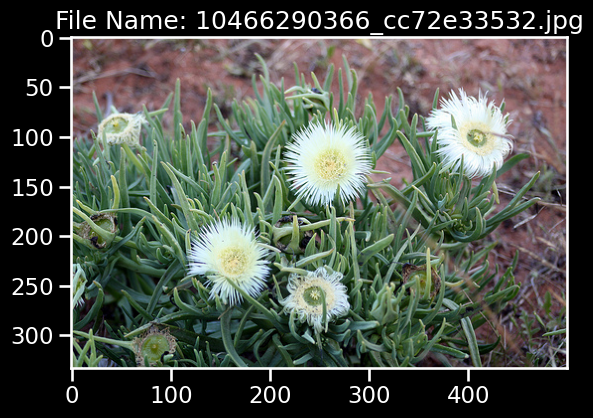

In [3]:
# view a few random images from the class daisy 
def view_random_image(root_path,folder):
    path=root_path+'/'+folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    print(f"image height:{random_image.shape}")
    plt.title("File Name: " + rand)

view_random_image(root, "daisy")


In [4]:
def show_number_of_classes_bar(root_folder):
  num_images = {}
  plt.figure(figsize=(15, 5))
  dir = os.listdir(root_folder)
  for i in dir:
    if i[-3:] !='txt':
      path = root +'/' + i
      num_images[i] = len(os.listdir(path))
      print(f"{i} = {num_images[i]} images")
  flowers = list(num_images.keys())
  values = list(num_images.values())
  plt.xlabel("number of images available")
  plt.ylabel("Image dataset")
  plt.barh(flowers, values, color = 'Red', capsize = 10)

tulips = 799 images
daisy = 633 images
roses = 641 images
dandelion = 898 images
sunflowers = 699 images


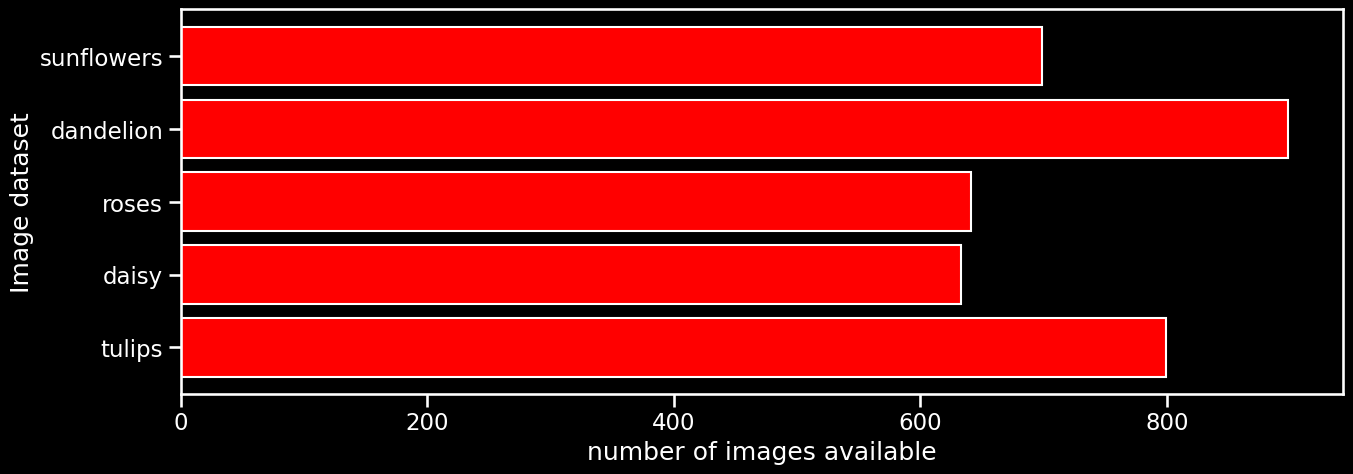

In [5]:
show_number_of_classes_bar(root)

*`There are different number of images per class`*

In [6]:
def show_number_of_classes_pie(root_folder):
  num_images = {}
  plt.figure(figsize=(15, 5))
  dir = os.listdir(root_folder)
  for i in dir:
    if i[-3:] !='txt':
      path = root +'/' + i
      num_images[i] = len(os.listdir(path))
      #print(f"{i} = {num_images[i]} images")
  labels = list(num_images.keys())
  counts = list(num_images.values())
  explode = (0.05, 0.05, 0.05, 0.05, 0.05)
  fig, ax = plt.subplots(figsize = (20, 12))
  ax.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
  ax.axis("equal") 

<Figure size 1500x500 with 0 Axes>

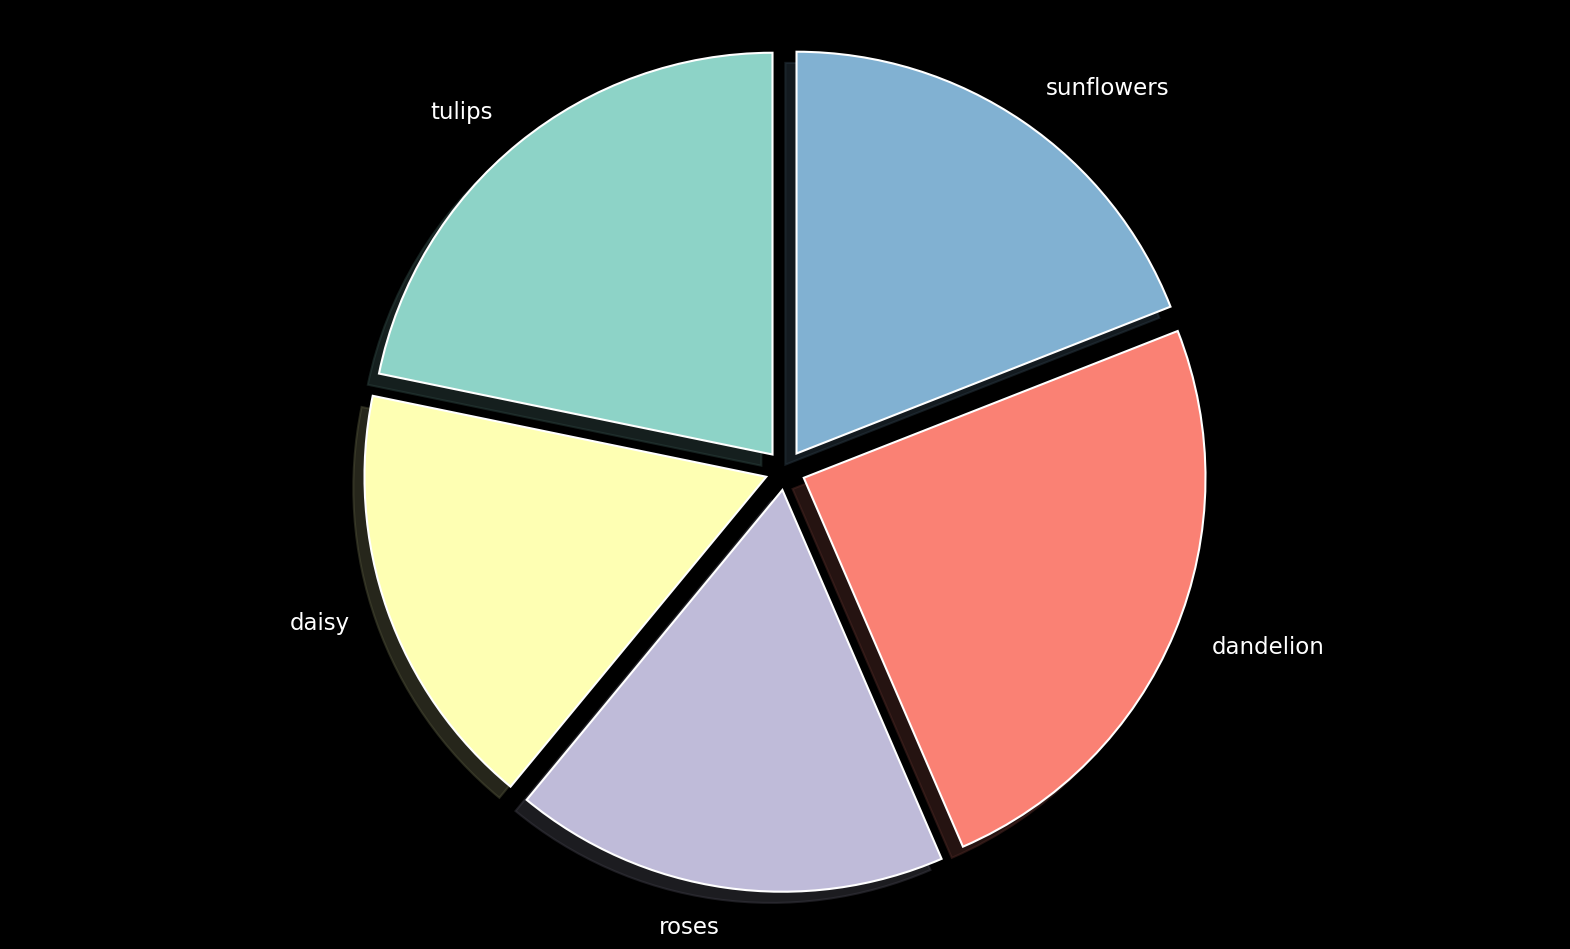

In [7]:
show_number_of_classes_pie(root)

In [33]:
# See more images to get a better understanding of the data
def show_more_images(root_folder):
  plt.figure(figsize=(25,25))
  index = 0
  dir = os.listdir(root_folder)
  for i in dir:
    if i[-3:] !='txt':
      path = root +'/' + i # removed LICENSE.txt
      rand=random.choice(os.listdir(path))
      random_image=mpimg.imread(path+'/'+rand)
      index += 1
      ax = plt.subplot(10,1,index)
      plt.title(f"File Name: {i}/{rand}, shape: {random_image.shape}")
      plt.imshow(random_image)
      plt.axis('off')

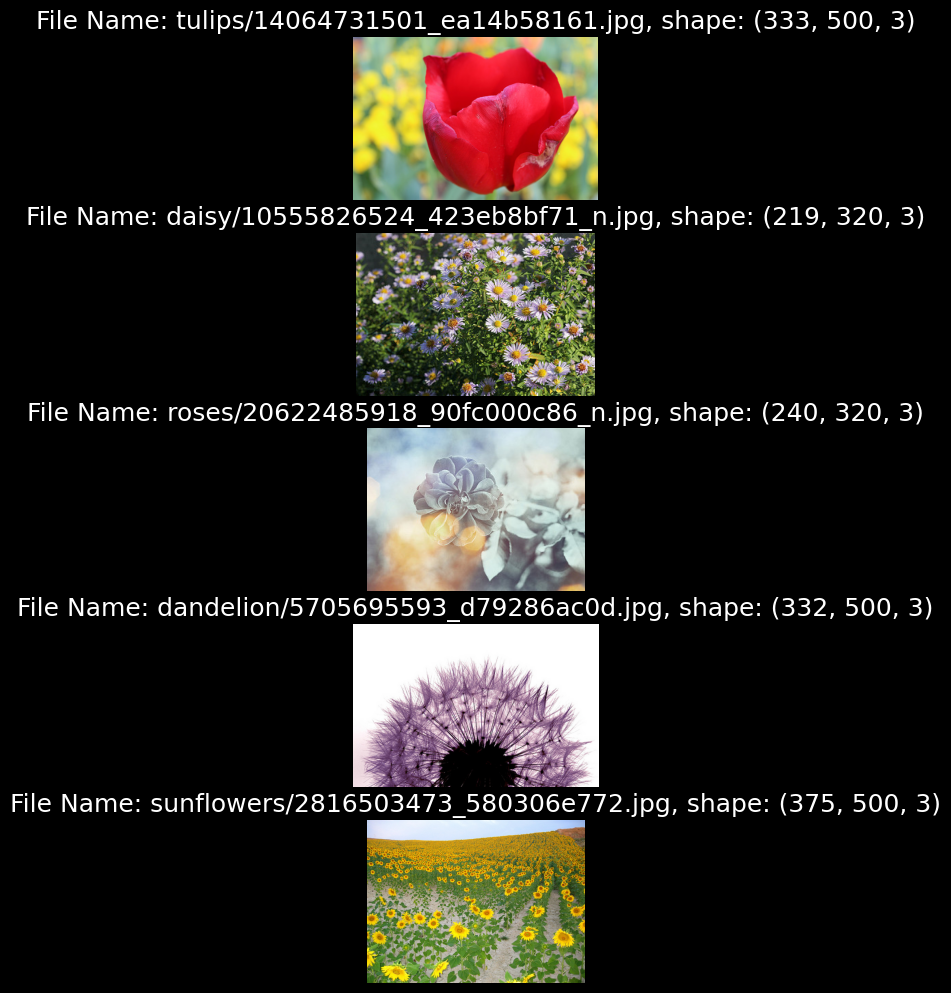

In [9]:
show_more_images(root)

*`point to remember: Images have varied shapes`*

In [10]:
# see image pixel sizes
def get_dims(file):
    """Returns dimensions for an RGB image"""
    im = PIL.Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

def image_pixel_sizes(root_folder):
  num_images = {}
  plt.figure(figsize=(15, 5))
  dir = os.listdir(root_folder)
  for i in dir:
    if i[-3:] !='txt':
      path = root +'/' + i
      filelist = [path + '/' + f for f in os.listdir(path)]
      dims = dask.bag.from_sequence(filelist).map(get_dims)
      with dask.diagnostics.ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(i))

[########################################] | 100% Completed | 4.62 s
[########################################] | 100% Completed | 2.09 s
[########################################] | 100% Completed | 2.26 s
[########################################] | 100% Completed | 2.69 s
[########################################] | 100% Completed | 2.48 s


<Figure size 1500x500 with 0 Axes>

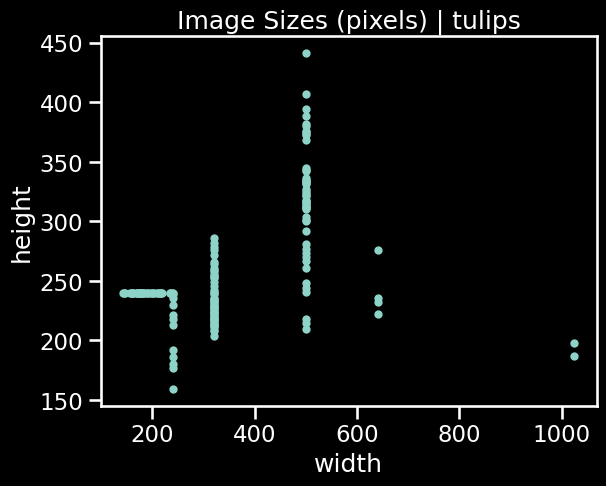

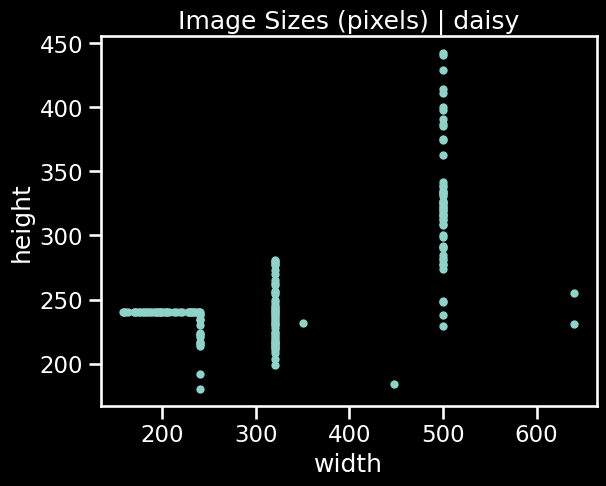

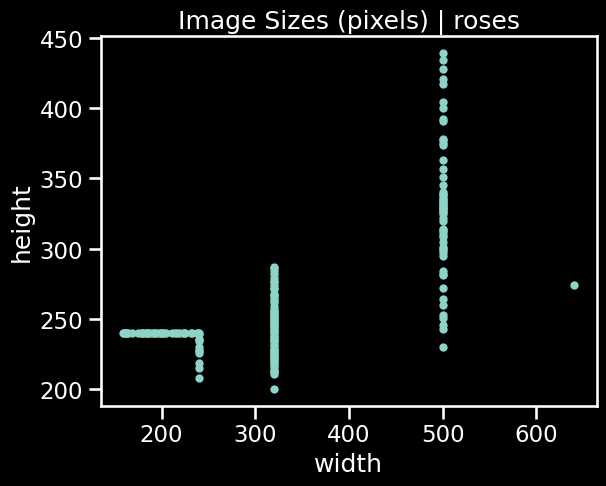

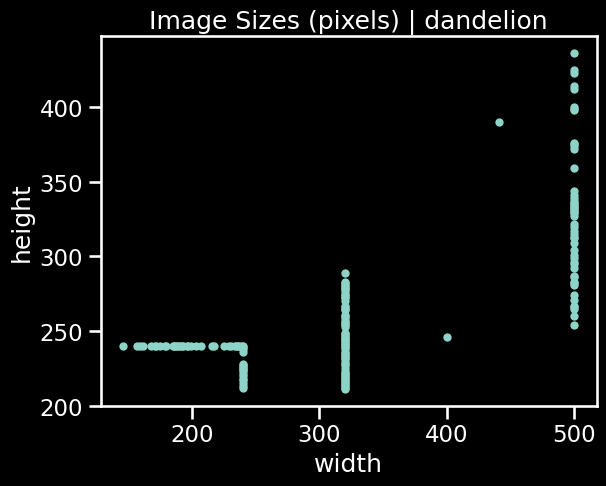

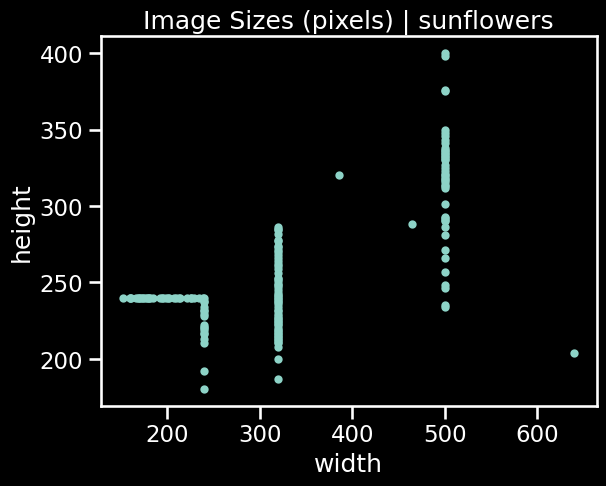

In [11]:
image_pixel_sizes(root)

*`Here we can see the destribution of different image sizes through out the dataset`*

### **Preprocessing**

In [12]:
def split_data(root_folder):
  labels = []
  img_paths = []
  dir = os.listdir(root_folder)
  for i in dir:
    if i[-3:] !='txt':
      path = root +'/' + i
      for pa in os.listdir(path):
        img_paths.append(path+'/'+pa)
        labels.append(i)
  impaths = pd.Series(img_paths, name='image_paths')
  lab = pd.Series(labels, name='labels')
  df=pd.concat([impaths, lab], axis=1)#Our initial df with image paths
  print(df) 
  #Split data 
  train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=42, stratify=df['labels'])
  valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=42, stratify=dummy_df['labels'])
  print(f'\ntrain_df has: {len(train_df)} images,  test_df has:  {len(test_df)} images, valid_df has: {len(valid_df)} images')

  return train_df, test_df, valid_df

In [13]:
train_df, test_df, val_df=split_data(root)

                                            image_paths      labels
0     /content/flower_photos/tulips/3238068295_b2a7b...      tulips
1     /content/flower_photos/tulips/5700466891_2bcb1...      tulips
2     /content/flower_photos/tulips/7144016605_e159b...      tulips
3     /content/flower_photos/tulips/8712268519_f4c2c...      tulips
4     /content/flower_photos/tulips/14057246122_8598...      tulips
...                                                 ...         ...
3665  /content/flower_photos/sunflowers/3912497870_a...  sunflowers
3666  /content/flower_photos/sunflowers/6606741847_f...  sunflowers
3667  /content/flower_photos/sunflowers/8478248531_1...  sunflowers
3668  /content/flower_photos/sunflowers/1297092593_e...  sunflowers
3669  /content/flower_photos/sunflowers/9904127656_f...  sunflowers

[3670 rows x 2 columns]

train_df has: 2936 images,  test_df has:  367 images, valid_df has: 367 images


In [14]:
def Augment(df, n, working_dir, img_size):
  print('Initial length of dataframe is ', len(df))
  
  
  augment_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
  os.mkdir(augment_dir)        
  
  
  for label in df['labels'].unique():    
      dir_path=os.path.join(augment_dir,label)    
      os.mkdir(dir_path) # make class directories within aug directory
  
  
  #counter variable for total augmented images
  total=0
  Aug_gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                height_shift_range=.2, zoom_range=.2)
  
  
  groups=df.groupby('labels') # store images grouped by class
  
  
  for label in df['labels'].unique():            
      group=groups.get_group(label)  # store image paths for a particular label
      number_of_images=len(group)   # determine how many samples there are in this class        
      if number_of_images< n: # if the class has less than target number of images
          aug_img_count=0 # counter variable for number of aug images created for that class
          difference=n - number_of_images  # number of augmented images to create
          target_dir=os.path.join(augment_dir, label)  # define where to write the images
          print(f'For {label} creating {difference} augmented images. ',end='')
          #print(msg, '\r', end='') # prints over on the same line
          aug_gen=Aug_gen.flow_from_dataframe( group,  x_col='image_paths', y_col=None, target_size=img_size,
                                          class_mode=None, batch_size=1, shuffle=False, 
                                          save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                          save_format='jpg')
          while aug_img_count < difference:
              # Generate augmented images and save them
              batch_images = next(aug_gen)
              aug_img_count += 1
              total += 1
              print(f'{aug_img_count}/{difference}', end=' ')
          print('\n')
  print('Total augmented images created: ', total)

In [15]:
n=800 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images, we will be using this variable as a universal variable
Augment(train_df, n, working_dir, img_size)    

Initial length of dataframe is  2936
For roses creating 287 augmented images. Found 513 validated image filenames.
1/287 2/287 3/287 4/287 5/287 6/287 7/287 8/287 9/287 10/287 11/287 12/287 13/287 14/287 15/287 16/287 17/287 18/287 19/287 20/287 21/287 22/287 23/287 24/287 25/287 26/287 27/287 28/287 29/287 30/287 31/287 32/287 33/287 34/287 35/287 36/287 37/287 38/287 39/287 40/287 41/287 42/287 43/287 44/287 45/287 46/287 47/287 48/287 49/287 50/287 51/287 52/287 53/287 54/287 55/287 56/287 57/287 58/287 59/287 60/287 61/287 62/287 63/287 64/287 65/287 66/287 67/287 68/287 69/287 70/287 71/287 72/287 73/287 74/287 75/287 76/287 77/287 78/287 79/287 80/287 81/287 82/287 83/287 84/287 85/287 86/287 87/287 88/287 89/287 90/287 91/287 92/287 93/287 94/287 95/287 96/287 97/287 98/287 99/287 100/287 101/287 102/287 103/287 104/287 105/287 106/287 107/287 108/287 109/287 110/287 111/287 112/287 113/287 114/287 115/287 116/287 117/287 118/287 119/287 120/287 121/287 122/287 123/287 124/287 1

In [32]:
def merge(t_df, aug_path):
   labels = []
   img_paths = []
   dir = os.listdir(aug_path)
   for lab in dir:
    im = aug_path+'/'+lab
    for i in os.listdir(im):
      img_paths.append(im+'/'+i)
      labels.append(lab)
   impaths = pd.Series(img_paths, name='image_paths')
   label = pd.Series(labels, name='labels')
   df=pd.concat([impaths, label], axis=1)
   
   # merging both the dataframes into a singular dataframe
   merged_df = pd.merge(df, t_df, how="outer") # 'outer' merge combines the rows from both DataFrames
   print(merged_df)
   return merged_df   

In [18]:
aug_df = merge(train_df, '/content/aug')

                                            image_paths      labels
0              /content/aug/tulips/aug-_106_8557183.jpg      tulips
1              /content/aug/tulips/aug-_155_6985342.jpg      tulips
2              /content/aug/tulips/aug-_153_6316163.jpg      tulips
3              /content/aug/tulips/aug-_124_3960162.jpg      tulips
4                /content/aug/tulips/aug-_2_5510504.jpg      tulips
...                                                 ...         ...
3995  /content/flower_photos/sunflowers/200011914_93...  sunflowers
3996  /content/flower_photos/tulips/8762193202_0fbf2...      tulips
3997  /content/flower_photos/sunflowers/8480886751_7...  sunflowers
3998  /content/flower_photos/sunflowers/23356825566_...  sunflowers
3999  /content/flower_photos/dandelion/2540640433_de...   dandelion

[4000 rows x 2 columns]


In [19]:
traingen0=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )


test_and_val_gen=ImageDataGenerator()

train_gen=traingen0.flow_from_dataframe(aug_df, x_col='image_paths', y_col='labels', target_size=(IMG_SIZE,IMG_SIZE),
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)

test_gen=test_and_val_gen.flow_from_dataframe(test_df, x_col='image_paths', y_col='labels', target_size=(IMG_SIZE,IMG_SIZE),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)


valid_gen=test_and_val_gen.flow_from_dataframe(val_df, x_col='image_paths', y_col='labels', target_size=(IMG_SIZE,IMG_SIZE),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=32)


Found 4000 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


### **Model Building**

# Now for our model, we use transfer learning with ResNet50V2 as our base model with Imagenet as its weights and adamax as its optimizer. Trainable is left true

In [22]:
model_base =ResNet50V2(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False,
)
model_base.trainable = True

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x= lyrs.Dropout(0.5, seed=42)(x)
outputs=lyrs.Dense(5, activation="softmax")(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                              

In [23]:
checkpointer = ModelCheckpoint('flower_model.hdf5',verbose=1, save_best_only= True)
weightpointer = ModelCheckpoint('model_weights.hdf5',verbose=1, save_best_only= True, save_weights_only=True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 5)

model.compile(loss="categorical_crossentropy", optimizer=Adamax(lr=1e-1), metrics=["accuracy"])
model_history=model.fit(x=train_gen, 
         steps_per_epoch=32,
         validation_data=valid_gen,
         epochs=50,
         callbacks=[checkpointer, weightpointer, early_stopping])

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.1534 - accuracy: 0.6328
Epoch 1: val_loss improved from inf to 16.71319, saving model to flower_model.hdf5

Epoch 1: val_loss improved from inf to 16.71319, saving model to model_weights.hdf5
32/32 [==============================] - 62s 688ms/step - loss: 1.1534 - accuracy: 0.6328 - val_loss: 16.7132 - val_accuracy: 0.3134
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.7119
Epoch 2: val_loss did not improve from 16.71319

Epoch 2: val_loss did not improve from 16.71319
32/32 [==============================] - 19s 590ms/step - loss: 0.8951 - accuracy: 0.7119 - val_loss: 19.1205 - val_accuracy: 0.3760
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7607
Epoch 3: val_loss improved from 16.71319 to 2.11493, saving model to flower_model.hdf5

Epoch 3: val_loss improved from 16.71319 to 2.11493, saving model to model_weights.hdf5
32/32 [====

### **Result Evaluation**

In [21]:
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

def loss_curve_plot(model_history):
    sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})

    training_acc =model_history.history['accuracy']
    training_loss=model_history.history['loss']
    val_acc=model_history.history['val_accuracy']
    val_loss=model_history.history['val_loss']


    Epoch_count=len(training_acc)
    Epochs=[]


    for i in range (0 ,Epoch_count):
        Epochs.append(i+1)   

    '''loss plot:'''
    fig,axes=plt.subplots(nrows=2, ncols=1, figsize=(15,13))
    axes[0].plot(Epochs,training_loss, '#ff7788', label='Training loss')
    axes[0].plot(Epochs,val_loss,'#6366f1',label='Validation loss' )
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    '''accuracy plot:'''
    axes[1].plot (Epochs,training_acc,'#ff7788',label= 'Training Accuracy')
    axes[1].plot (Epochs,val_acc,'#6366f1',label= 'Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend() 
    plt.show()
    
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

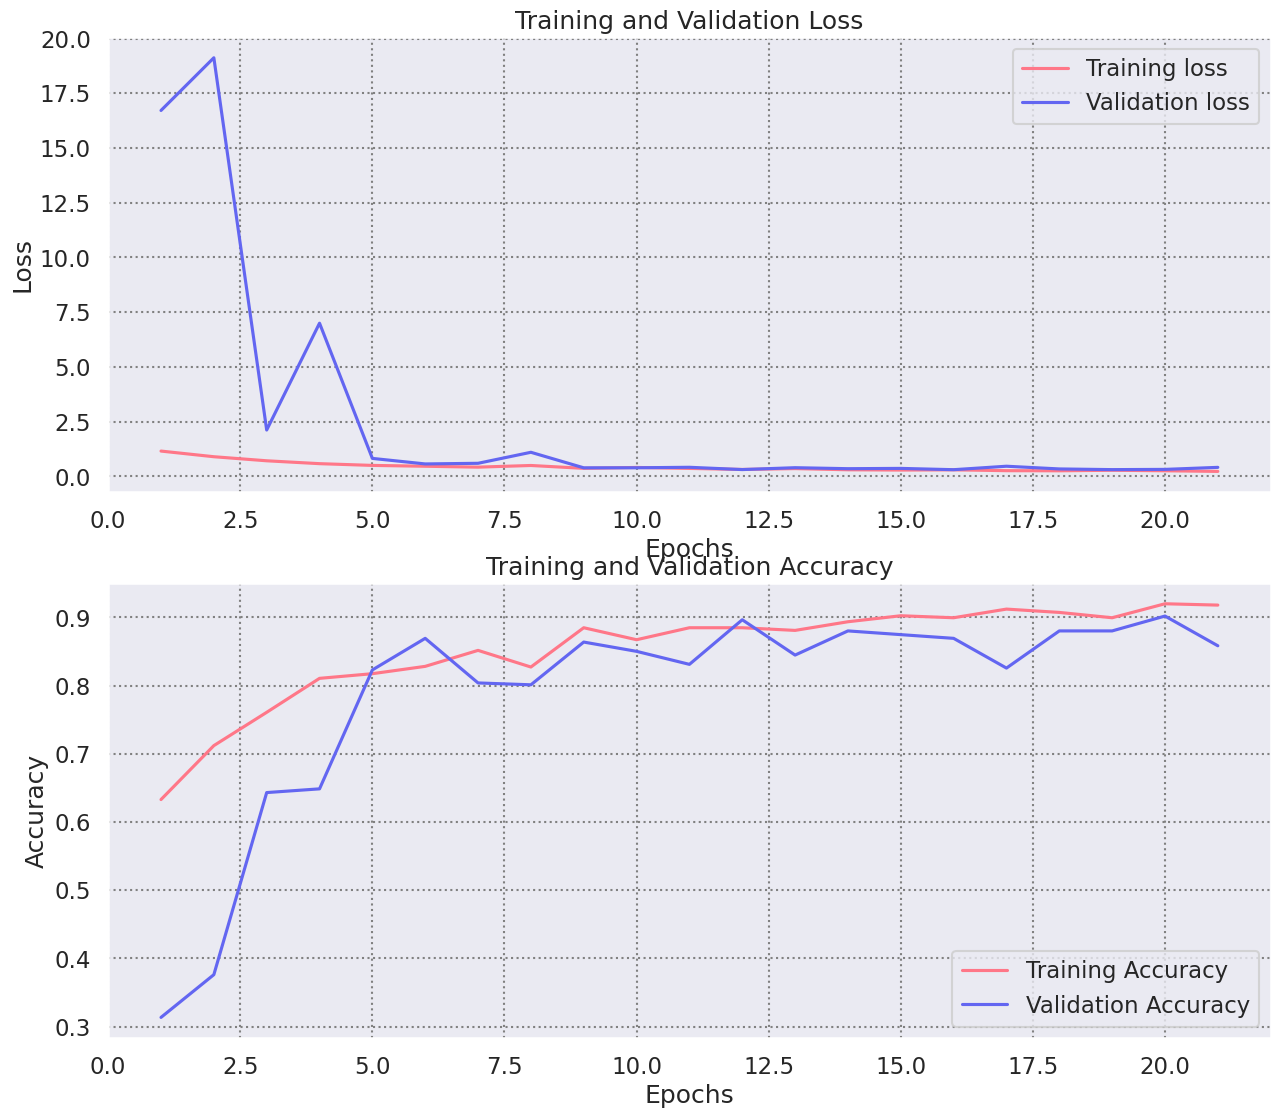

In [24]:
loss_curve_plot(model_history)

In [25]:
from sklearn.metrics import classification_report

In [27]:
y_pred= []#store predictions
y_true=test_gen.labels
classes=list(test_gen.class_indices.keys())
class_count=len(classes)
errors=0 #store errors
preds=model.predict(test_gen, verbose=1)
    
tests=len(preds)    
    
#loop to check the number of errors    
for i, j in enumerate(preds):        
    pred_index=np.argmax(j)         
    true_index=test_gen.labels[i]      
    if pred_index != true_index: # is predicted label=true label?                                           
        errors=errors + 1
    y_pred.append(pred_index)

ypred=np.array(y_pred)
ytrue=np.array(y_true)

supervised_metrics(y_true, y_pred)

12/12 [==============================] - 2s 169ms/step
Accuracy : 89.91825613079018 %
F1 Score : 0.9003221670458156
Recall : 0.8991825613079019
Precision : 0.9129582349226399


In [28]:
acc=(1-(errors/tests))* 100 
print(f'Model made {errors} errors out  {tests} images. Accuracy = {acc:6.2f}%')
    
report = classification_report(y_true, y_pred, target_names=classes, digits= 4) # storeclassification report
print("\nClassification Report:\n", report)

Model made 37 errors out  367 images. Accuracy =  89.92%

Classification Report:
               precision    recall  f1-score   support

       daisy     0.9538    0.9688    0.9612        64
   dandelion     1.0000    0.8764    0.9341        89
       roses     0.9216    0.7344    0.8174        64
  sunflowers     0.9571    0.9571    0.9571        70
      tulips     0.7379    0.9500    0.8306        80

    accuracy                         0.8992       367
   macro avg     0.9141    0.8973    0.9001       367
weighted avg     0.9130    0.8992    0.9003       367



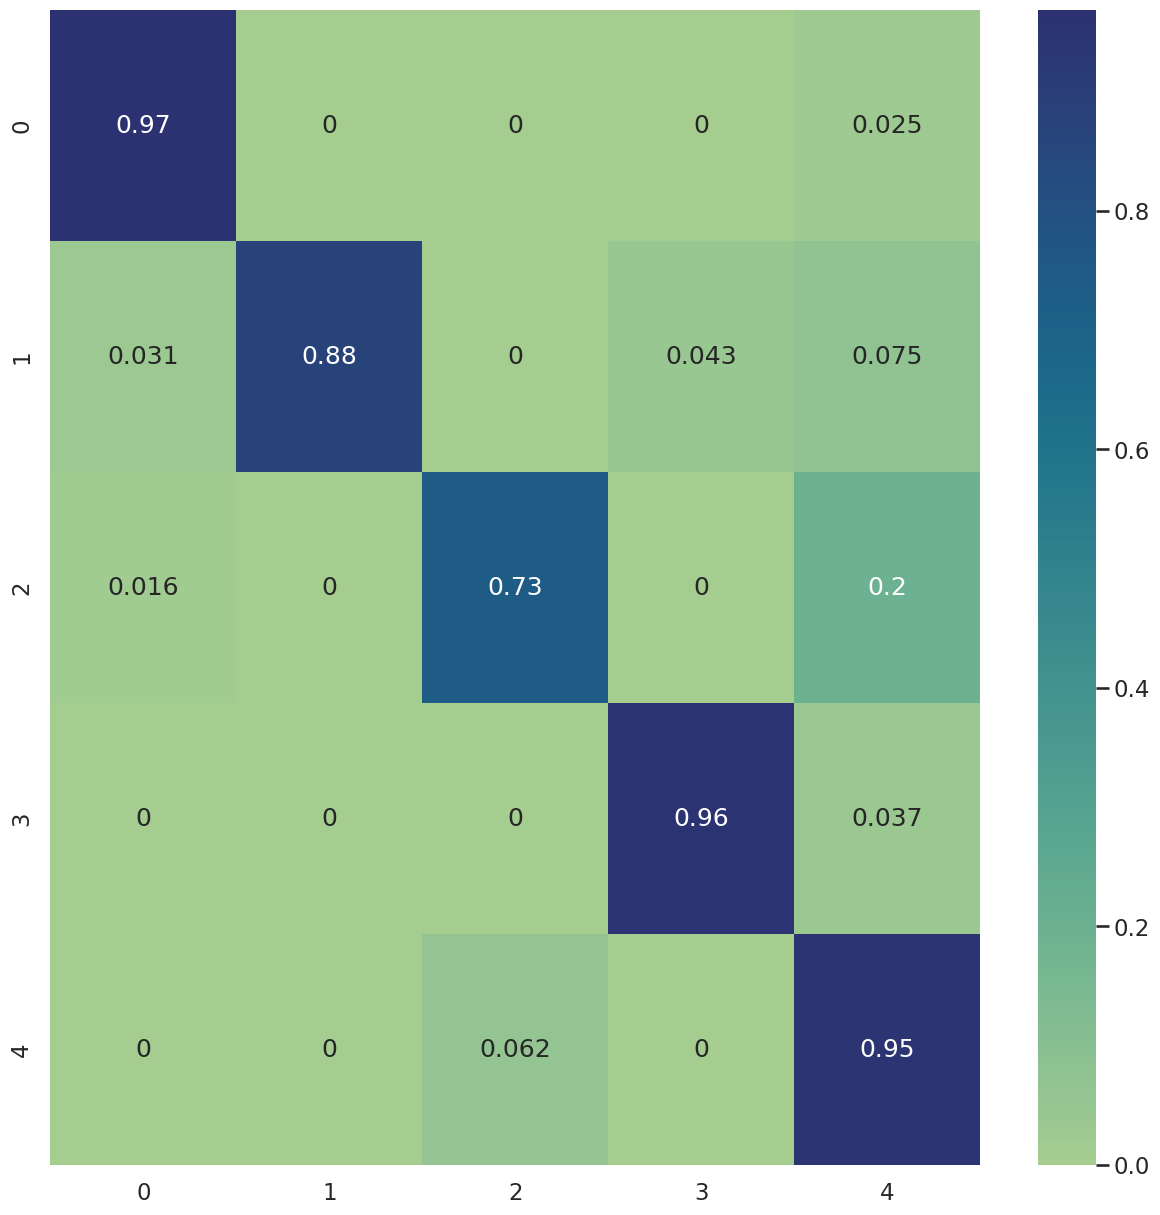

In [31]:
confusion_matrix_plot(y_true, y_pred, figsize=(15,15))

# Thus our ResNet50V2 model gives training accuracy of 85%, this can be further improved with experimentation using different optimizers and using lower learning rate.